# 1. 라이브러리 로드

In [1]:
!pip install transformers torch sentencepiece multiprocess pyrouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.2 MB/s eta 0:00:00
  Created wheel for pyrouge: filename=pyrouge-0.1.3-py3-none-any.whl size=191604 sha256=7dc7b14e2b9fa5e4ad8f4eb8d06a100f41b45b9770b65808b065a8e53bf28f43
  Stored in directory: /root/.cache/pip/wheels/9a/67/12/c5dd8ef8b4152bb8789eafd2a74a734e2dc7bb9eae02b768e7
Successfully built pyrouge


In [3]:
# %%bash
# git clone https://github.com/uoneway/KoBertSum.git

In [24]:
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast
import torch

import pandas as pd

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import re

# 2. 데이터 로드

In [4]:
refined_news_df = pd.read_csv('/content/drive/MyDrive/estate_volume_analysis/refined_district_news.csv', index_col=0)
refined_news_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17075 entries, 0 to 17074
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        17075 non-null  object
 1   link         17075 non-null  object
 2   article      17075 non-null  object
 3   date         17075 non-null  object
 4   media        17075 non-null  object
 5   region_code  17075 non-null  int64 
 6   region       17075 non-null  object
 7   district     17075 non-null  object
 8   yyyymm       17075 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.3+ MB


In [25]:
# 신문사명 제거
media_list = refined_news_df['media'].unique().tolist()

others = [
          '기자', '머니', '투데이', '트위터', '자료', '사진',
          '아시아', '뉴스', '있는', '구는', '지난', '위해', '보는', '댓글', '지역'
          'Copyright', '(C)', '뉴스1', 'All', 'rights', 'reserved'
        ]

stopwords = media_list + others

def preprocess_text_mecab(text):

    # 1. 단어 추출
    tokens = text.split(' ')

    # 2. 불용어 필터링 (불용어가 포함된 단어 제거)
    filtered_tokens = []
    for token in tokens:

        # 정규식으로 stopwords를 포함한 단어 제거
        if not any(re.search(rf"\b{re.escape(word)}", token) for word in stopwords):
            filtered_tokens.append(token)

    return " ".join(filtered_tokens)


refined_news_df['preprocessed_article'] = refined_news_df['article'].apply(preprocess_text_mecab)
refined_news_df.head()

,title,link,article,date,media,region_code,region,district,yyyymm,text_length,text_token_length,article_summary,preprocessed_article
0,서울 '알짜배기' 땅 매물로 나왔다…86억 강남 파출소 부지,https://n.news.naver.com/article/277/0005477904,최소 입찰 예정가격 86억1298만원서울 강남구 '노른자위 땅'에서 10년 넘게 방...,2024.09.29,아시아경제,1168000000,강남구,동남권,2024-09-01,579,252,\n 최소 입찰 예정가격 86억1298만원서울 강남구 '노른자위 땅'에서 10년 넘...,최소 입찰 예정가격 86억1298만원서울 강남구 '노른자위 땅'에서 10년 넘게 방...
1,[단독]서울시 10년 간 싱크홀 223건…강남구 28건 가장 많아,https://n.news.naver.com/article/018/0005843496,2015년~2024년 9월 1일까지 서울시 싱크홀 233건 중강남구 28건 가장多…...,2024.09.26,이데일리,1168000000,강남구,동남권,2024-09-01,1648,725,있다.\n 2015년~2024년 9월 1일까지 서울시 싱크홀 233건 중강남구 28...,2015년~2024년 9월 1일까지 서울시 싱크홀 233건 중강남구 28건 가장多…...
2,양재역 인근에 18층 오피스…역세권 활성화 선정,https://n.news.naver.com/article/277/0005475883,환승역세권 350m까지 대상지 확대개정 기준 반영 첫 사례서울 지하철 3호선과 신분...,2024.09.25,아시아경제,1168000000,강남구,동남권,2024-09-01,689,306,있다. 환승역세권 350m까지 대상지 확대개정 기준 반영 첫 사례서울 지하철 3호선...,환승역세권 350m까지 대상지 확대개정 기준 반영 첫 사례서울 지하철 3호선과 신분...
3,압구정5구역 ‘70층 재건축’ 공식화,https://n.news.naver.com/article/016/0002366447,"구청, 정비구역·계획 변경안 공고100억원대 펜트하우스 6채 구성조합원 106㎡ 분...",2024.09.25,헤럴드경제,1168000000,강남구,동남권,2024-09-01,1348,657,"구청,, 정비구역·계획 변경안 공고100억원대 펜트하우스 6채 구성조합원 106m2...","구청, 정비구역·계획 변경안 공고100억원대 펜트하우스 6채 구성조합원 106㎡ 분..."
4,"강남 구룡마을, 13년 만 보상 돌입했지만…'비닐하우스'가 발목",https://n.news.naver.com/article/011/0004395106,"SH공사, 토지 등 소유자 수용재결 신청···수용 돌입토지 소유자 52%, 지장물 ...",2024.09.24,서울경제,1168000000,강남구,동남권,2024-09-01,1882,815,"했다. SH공사, 토지 등 소유자 수용재결 신청···수용 돌입토지 소유자 52%, ...","SH공사, 토지 등 소유자 수용재결 신청···수용 돌입토지 소유자 52%, 지장물 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17070,중랑구 ‘서촌노인문화센터’ 개관,https://n.news.naver.com/article/277/0002413614,중랑구 서촌노인문화센터[아시아경제 박종일 기자]중랑구(구청장 문병권)가 어르신들이 ...,2010.07.16,아시아경제,1126000000,중랑구,동북권,2010-07-01,1233,597,NaN,중랑구 박종일 문병권)가 어르신들이 편안한 노후생활을 즐길 수 있도록 쾌적한 휴식공...
17071,문병권 중랑구청장의 '교육특구' 열정 넘쳐,https://n.news.naver.com/article/277/0002399893,문병권 중랑구청장[아시아경제 박종일 기자]'교육 구청장'으로 불리우는 문병권 중랑구...,2010.06.24,아시아경제,1126000000,중랑구,동북권,2010-06-01,1805,842,NaN,"문병권 박종일 구청장'으로 불리우는 문병권 중랑구청장은 ""젊은 구민이 늘어나 지역사..."
17072,"중랑구, 주택재건축 갈등 해소 앞장",https://n.news.naver.com/article/277/0002396170,문병권 중랑구청장[아시아경제 박종일 기자]중랑구(구청장 문병권)는 주택재건축 등 정...,2010.06.18,아시아경제,1126000000,중랑구,동북권,2010-06-01,815,376,NaN,문병권 박종일 문병권)는 주택재건축 등 정비사업 시행으로 인해 발생되는 조합과 조합...
17073,"[Seoul 요모조모-만원의 행복] 중랑 ‘사색의 길’, ‘장미터널’",https://n.news.naver.com/article/081/0002091428,[서울신문]서울과 경기 구리시를 연결하고 있는 망우리 고개를 넘어가다 보면 우측에 ...,2010.06.18,서울신문,1126000000,중랑구,동북권,2010-06-01,1701,843,NaN,경기 구리시를 연결하고 망우리 고개를 넘어가다 보면 우측에 숲이 무성한 공원묘지를 ...


# 3. 뉴스 기사 텍스트 토큰 수 분포 파악

In [10]:
tokenizer = PreTrainedTokenizerFast.from_pretrained('hyunwoongko/kobart')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/337 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/109 [00:00<?, ?B/s]

In [11]:
# 띄어쓰기가 포함된 각 뉴스 기사 별 텍스트 길이 파악
refined_news_df['text_length'] = refined_news_df['article'].apply(lambda x: len(x))
refined_news_df['text_token_length'] = refined_news_df['article'].apply(lambda x: len(tokenizer.encode(x, truncation=False)))

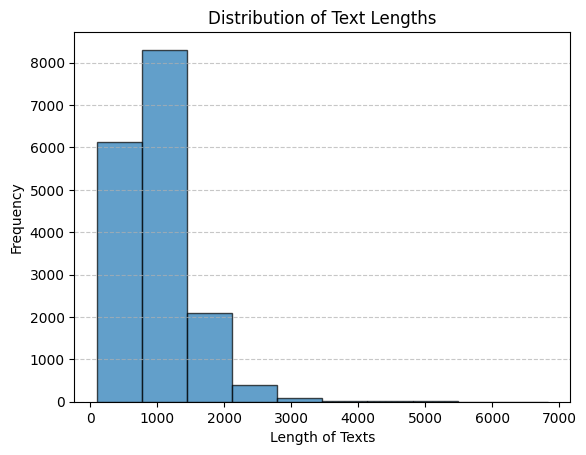

텍스트 길이 통계:
count    17075.000000
mean      1010.031918
std        508.081438
min        101.000000
25%        668.000000
50%        905.000000
75%       1227.500000
max       6833.000000
Name: text_length, dtype: float64


In [12]:
# 길이 분포 시각화
plt.hist(refined_news_df['text_length'], bins=10, alpha=0.7, edgecolor='black')
plt.title("Distribution of Text Lengths")

plt.xlabel("Length of Texts")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# 길이 통계 확인
print("텍스트 길이 통계:")
print(refined_news_df['text_length'].describe())

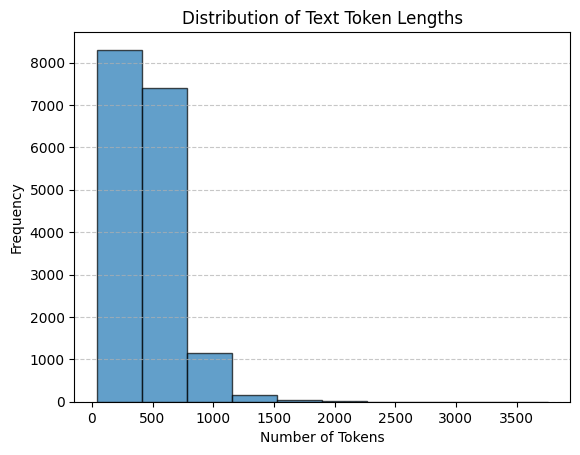

토큰 수 통계:
count    17075.00000
mean       461.60328
std        228.48637
min         42.00000
25%        308.00000
50%        419.00000
75%        559.00000
max       3758.00000
Name: text_token_length, dtype: float64


In [13]:
# 토큰 수 분포 시각화
plt.hist(refined_news_df['text_token_length'], bins=10, alpha=0.7, edgecolor='black')
plt.title("Distribution of Text Token Lengths")

plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

print("토큰 수 통계:")
print(refined_news_df['text_token_length'].describe())

In [14]:
# KoBART 모델 특성 상, 토큰 수가 1024개 이상인 뉴스 기사에 대해서 요약 불가 (17,075개 중 372개)
# 입력 토큰 수가 1024개 이상인 뉴스 기사에 대하여 split text 로직 적용
len(refined_news_df[refined_news_df['text_token_length'] > 1024])

372

# 4. 뉴스 기사 요약

## 4.1 KoBART

In [49]:
encode_max_length = 1024 # KoBART 에서 처리할 수 있는 최대 토큰 수
stride = 512

length_penalty = 1

max_ratio = 0.6
min_ratio = 0.4

device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
# KoBART 모델 및 토크나이저 로드
model = BartForConditionalGeneration.from_pretrained('hyunwoongko/kobart').to(device)

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


pytorch_model.bin:   0%|          | 0.00/496M [00:00<?, ?B/s]

In [17]:
def split_text(text, max_length=1024, stride=512):

    """
        - 긴 텍스트를 max_length와 stride를 기반으로 분할.
        - stride는 max_length 값의 절반으로 설정, 너무 작으면 문맥이 단절될 수 있음

        1. 긴 텍스트를 max_length 기준으로 자릅니다.
        2. stride를 활용하여 앞 조각의 끝 부분과 다음 조각의 시작 부분이 겹치도록 만듭니다.
        3. 겹치는 부분을 포함하면 문맥 단절을 방지하여 모델의 성능을 높일 수 있습니다.
    """

    # 전체 텍스트를 토큰화
    tokens = tokenizer.encode(text, truncation=False)

    # 슬라이딩 윈도우 방식으로 텍스트 나누기
    chunks = []
    for i in range(0, len(tokens), max_length - stride):
        chunk = tokens[i:i + max_length]
        chunks.append(chunk)
        if i + max_length >= len(tokens):  # 마지막 청크 처리
            break

    return chunks

In [50]:
for value in tqdm(refined_news_df.itertuples(), total=len(refined_news_df)):

    article = value.preprocessed_article

    # 1024개보다 더 많은 토큰 수 갖는 기사의 경우,
    # split text 로직 적용
    if value.text_token_length > encode_max_length:

        # 텍스트 분할
        token_chunks = split_text(article)

        # 각 청크를 요약하고 결과를 합침
        summaries = []
        for chunk in token_chunks:
            inputs = torch.tensor([chunk]).to(device)  # 모델 입력 형태로 변환

            max_length = int(len(inputs[0]) * max_ratio) # 주어진 뉴스 기사 원문 토큰 길이의 50%
            min_length = int(len(inputs[0]) * min_ratio) # 주어진 뉴스 기사 원문 토큰 길이의 20%

            summary_ids = model.generate(
                inputs,
                max_length=max_length,
                min_length=min_length,
                length_penalty=length_penalty,
                num_beams=4
            )
            summaries.append(tokenizer.decode(summary_ids[0], skip_special_tokens=True))

        refined_news_df.loc[value.Index, 'article_summary'] = ' '.join(summaries)


    # 1024개보다 작은 토큰 수 갖는 기사의 경우,
    else:

        article_tensor = tokenizer.encode(
            article,               # 처리할 텍스트 (뉴스 기사, 문장 등)
            return_tensors="pt",   # 반환 형태를 PyTorch 텐서로 지정 (TensorFlow 사용 시 'tf'로 변경 가능)
            max_length=encode_max_length,       # 텍스트의 최대 길이를 max_length 만큼 토큰으로 제한
            truncation=False
        ).to(device)

        max_length = int(len(article_tensor[0]) * max_ratio) # 주어진 뉴스 기사 원문 토큰 길이의 50%
        min_length = int(len(article_tensor[0]) * min_ratio) # 주어진 뉴스 기사 원문 토큰 길이의 20%


        # 요약문 생성
        summary_ids = model.generate(
            article_tensor,
            max_length=max_length,       # 생성되는 텍스트의 최대 길이 (토큰 기준). 너무 길면 비효율적이거나 원문처럼 길어질 수 있음.
            min_length=min_length,        # 생성되는 텍스트의 최소 길이. 너무 짧으면 불완전한 요약문이 생성될 수 있음.
            length_penalty=length_penalty,   # 텍스트 길이에 대한 가중치. 1.0보다 크면 긴 텍스트를, 작으면 짧은 텍스트를 선호.
            num_beams=4          # Beam Search에서 고려할 경로의 개수. 더 많은 경로를 탐색하면 품질이 높아질 수 있으나 속도가 느려짐.
        )
        article_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

        refined_news_df.loc[value.Index, 'article_summary'] = article_summary

  0%|          | 0/17075 [00:00<?, ?it/s]

In [53]:
refined_news_df.to_csv('refined_news_summary.csv', encoding='utf-8-sig')